# 가위바위보 분류기

## 1. 사전 준비 
  1) 필요한 라이브러리 import<br>
  2) 이미지 사이즈 조절 함수 정의<br>
  3) 훈련용 이미지 정보 준비 및 사이즈 변경( 28 x 28 )  <br>

### 1) PIL, os, glob, np, plt library import

In [11]:
from PIL import Image
import os, glob
import numpy as np
import matplotlib.pyplot as plt

print("라이브러리 import 완료!")

라이브러리 import 완료!


### 2)  이미지 사이즈 조절 함수 정의

In [12]:
# 이미지 사이즈 조절 함수 정의
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")

### 3) 훈련용 이미지 정보 준비 및 사이즈 변경 ( 28 x 28 )

In [7]:
# 가위/바위/보 이미지 변환 
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
resize_images(image_dir_path)
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"
resize_images(image_dir_path)
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
resize_images(image_dir_path)

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


## 2. 데이터 로드 및 전처리
 1) 데이터 로드 함수정의
 2) 데이터이미지 로드
 3) 데이터 정규화

### 1) 데이터 로드 함수 정의

In [13]:
def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels    

### 2) 데이터이미지 로드

In [14]:
# 데이터 로드 및 전처리
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/"
(x_train, y_train)=load_data(image_dir_path)

학습데이터(x_train)의 이미지 개수는 300 입니다.


### 3) 데이터 정규화 


x_train shape: (300, 28, 28, 3)
y_train shape: (300,)
라벨:  0


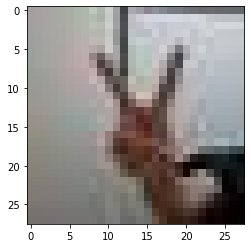

In [15]:
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

# 이미지 확인
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

## 3. 딥러닝 네트워크 설계하기

In [16]:
# 딥러닝 네트워크 설계하기
import tensorflow as tf
from tensorflow import keras

# model 생성
n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25632     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3

In [17]:
# 데이터 확인
x_train_norm.shape
y_train.shape

(300,)

## 4. 딥러닝 학습시키기

In [18]:
# 딥러닝 네트워크 학습시키기
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=10)

Epoch 1/10
10/10 [==============================] - 5s 175ms/step - loss: 2.1462 - accuracy: 0.2456
Epoch 2/10
10/10 [==============================] - 0s 3ms/step - loss: 1.3753 - accuracy: 0.3607
Epoch 3/10
10/10 [==============================] - 0s 3ms/step - loss: 1.1038 - accuracy: 0.3729
Epoch 4/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0370 - accuracy: 0.6080
Epoch 5/10
10/10 [==============================] - 0s 3ms/step - loss: 0.9829 - accuracy: 0.6151
Epoch 6/10
10/10 [==============================] - 0s 3ms/step - loss: 0.8517 - accuracy: 0.8402
Epoch 7/10
10/10 [==============================] - 0s 3ms/step - loss: 0.7036 - accuracy: 0.9067
Epoch 8/10
10/10 [==============================] - 0s 3ms/step - loss: 0.5742 - accuracy: 0.9036
Epoch 9/10
10/10 [==============================] - 0s 3ms/step - loss: 0.4336 - accuracy: 0.9008
Epoch 10/10
10/10 [==============================] - 0s 3ms/step - loss: 0.3313 - accuracy: 0.9396


## 5. 테스트 데이터 준비

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)
라벨:  0


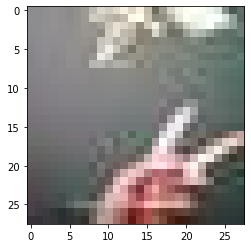

In [19]:
# 테스트 데이터 준비 ( '/aiffel/rock_scissor_paper/test/' )
test_image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/"
(x_test, y_test)=load_data(test_image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

# 이미지 확인
plt.imshow(x_test[0])
print('라벨: ', y_test[0])

## 6. 테스트 수행

In [20]:
# 테스트 데이터로 성능확인 ( 첫번째 테스트 데이터 )
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 1.1989 - accuracy: 0.3867
test_loss: 1.1988725662231445 
test_accuracy: 0.3866666555404663


## 7. 테스트 결과 확인

In [21]:
predicted_result = model.predict(x_test_norm)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test[idx])

model.predict() 결과 :  [2.2985351e-01 4.4213957e-01 3.2799137e-01 1.0982813e-05 4.2401857e-07
 5.5785741e-11 4.8992238e-08 3.6643030e-06 4.2619402e-07 1.0488206e-08]
model이 추론한 가장 가능성이 높은 결과 :  1
실제 데이터의 라벨 :  0


### 1) 테스트 결과 가장 가능성 높은 이미지

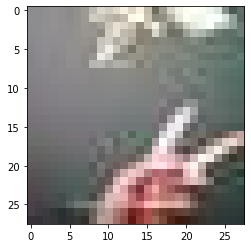

In [22]:
plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

### 2) 테스트 결과와 다르게 예측한 이미지 

예측확률분포: [2.8125867e-01 1.2883335e-01 5.8989245e-01 1.1528134e-05 3.9339957e-07
 4.1712148e-11 3.9541472e-08 2.8256727e-06 7.8665175e-07 7.8273485e-09]
라벨: 0, 예측결과: 2


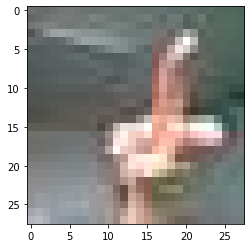

예측확률분포: [4.45761293e-01 3.94247919e-01 1.59983262e-01 5.26312897e-06
 1.04732315e-07 4.99599580e-12 7.76932829e-09 1.99061424e-06
 9.48664081e-08 1.69095060e-09]
라벨: 1, 예측결과: 0


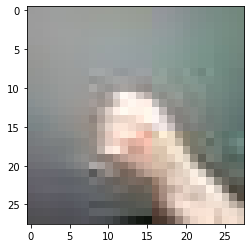

예측확률분포: [4.3788844e-01 2.7711477e-02 5.3439343e-01 5.6814119e-06 1.1914924e-07
 4.1902410e-12 5.6893468e-09 5.7338275e-07 3.2271484e-07 9.4608177e-10]
라벨: 1, 예측결과: 2


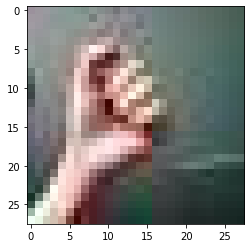

예측확률분포: [1.4781092e-01 6.2770861e-01 2.2444417e-01 2.6057860e-05 7.2089193e-07
 2.8943151e-10 1.6861371e-07 8.5984129e-06 7.5262835e-07 2.0174134e-08]
라벨: 2, 예측결과: 1


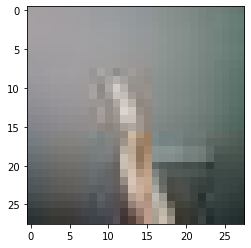

예측확률분포: [7.3387474e-02 1.8083706e-01 7.4576622e-01 7.2410216e-06 2.5093473e-07
 3.1734070e-11 4.8889991e-08 1.2565142e-06 4.4416529e-07 3.0520830e-09]
라벨: 1, 예측결과: 2


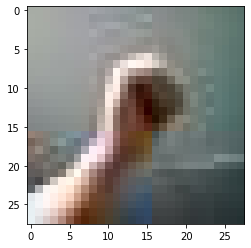

In [24]:
# 오류 데이터 5개만 추출
import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다.
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()

## 8. 더 좋은 네트워크 만들기

### 1) 하이퍼파라미터 조정 ( 16 / 32 / 32 / 10 => loss: 1.1024 - accuracy: 0.4200 )

In [25]:
# 더 좋은 네트워크 만들어 보기

# 바꿔 볼 수 있는 하이퍼파라미터들 
# 16 / 32 / 32 / 10 ( loss: 1.1081 - accuracy: 0.3933 )
n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train_norm, y_train, epochs=n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                25632     
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

### 2) 하이퍼파라미터 조정 ( 32 / 32 / 32 / 10 => loss: 1.0850 - accuracy: 0.4567 )

In [26]:
# 더 좋은 네트워크 만들어 보기
n_channel_1=32
n_channel_2=32
n_dense=32
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train_norm, y_train, epochs=n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                25632     
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [28]:
### 3) 하이퍼파라미터 조정 ( 32 / 32 / 16 / 10 => loss: 1.2040 - accuracy: 0.4500 )

In [27]:
# 더 좋은 네트워크 만들어 보기
n_channel_1=32
n_channel_2=32
n_dense=16
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train_norm, y_train, epochs=n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                12816     
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

# **파라미터 조정만으로는 원하는 수치가 나오지 않음** 
 * 추가 데이터 학습 진행 : 전지은님이 모아주신 3,207 개의 데이터로 추가학습 결정

# 9. 추가 데이터 준비 ( 3,207, /rock_scissor_paper_others/ ) 

학습데이터(x_train)의 이미지 개수는 3207 입니다.
x_add_train shape: (3207, 28, 28, 3)
y_add_train shape: (3207,)
다른 사람의 데이터 라벨:  0


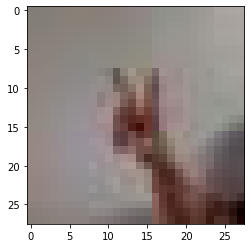

In [29]:
# 추가 데이터 준비 ( 3,207 )
other_image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper_others/"
(x_add_train, y_add_train)=load_data(other_image_dir_path, 3207)

# 데이터 정규화
x_add_train_norm = x_add_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_add_train shape: {}".format(x_add_train.shape))
print("y_add_train shape: {}".format(y_add_train.shape))

# 이미지 확인
plt.imshow(x_add_train[0])
print('다른 사람의 데이터 라벨: ', y_add_train[0])

# 10. 추가된 데이터로 모델 훈련 및 시험 ( 16 / 32 / 32 / 10 =>  loss: 0.3058 - accuracy: 0.9167 )

In [30]:
# 추가 데이터 학습
n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_add_train_norm, y_add_train, epochs=n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                25632     
_________________________________________________________________
dense_9 (Dense)              (None, 10)               

# ** 훈련 횟수가 부족해보여서 훈련횟수 20회로 증가

# 11. 하이퍼파라미터 조정 ( 16 / 32 / 32 / 20 => loss: 0.0960 - accuracy: 0.9800 )

In [31]:
# 추가 데이터 학습 ( 기본값 진행시 n_train_epoch : 10 증가 )
n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=20

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_add_train_norm, y_add_train, epochs=n_train_epoch)

# 모델 시험
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                25632     
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

#  **test accuracy가 98%로 나옴!!!!!! - (맞게... 는 한건가?) ㅠㅠ
   

# ** 회고 **

## 1. 이번 프로젝트에서 **어려웠던 점,**

* 처음으로 Exploration을 진행하다보니, 무엇을 어떻게 해야하는지를 잘 몰라서 난감했음
* 첫 딥러닝 프로젝트여서 이해가 안 가는 부분이 많았고, 아직 주피터를 잘 못 사용하는 부분이 시간을 많이 잡아먹었음
* kerasAPI를 처음 사용해보았으며, 하면서도 이게 맞게 하는건지에 대한 의문이 들었음
 ( 실제로 올바르게 한건지 잘 모르겠음 )

## 2. 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.


**알아낸점**
   * 주피터를 이용하는 법에 대해서 의지를 갖고 진행했음( 세상엔 좋은 툴이 많구나 하는것 을 느꼈음 )
   * 모델에 대한 학습에는 데이터의 양이 너무 적으면 원하는 결과를 못 얻을 수 있다는 것을 알게 됨
 
**모호한점**
   * 위에서 진행을 처음에 직접 만든 300개의 이미지로 훈련을 하고, 다른 분이 만든 300개로 테스트를 진행했는데.. 이렇게 해도 맞는건지..
   * 수치를 올리기위해 위처럼 진행한 것이 처음 진행했던 300개 이미지와는 상관없이 아얘 3천여개의 이미지로만 테스트한 것이 되는건지..

## 3. 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.


* 하이퍼파라미터의 값을 변경하면서 수행해 봄 (위의 소스보다 실제로는 다양(10가지 경우 등)하게 하이퍼파라미터값을 수정해봤었음 )
  <br>=> 그러나 별다른 차이를 못 느낌
  
* 다른 분(`전지은님`)이 모아놓은 대량의 데이터로 훈련을 시도했음

## 4. 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.



* 위에 진행한게 실제 지표를 달성했는지 잘 모르겠습니다. ㅠㅠ

## - **자기 다짐**

* 아직 시작하는 단계인데.. 재미있습니다.
* 진행하고 있는 이 단계들을 100% 다 이해했다면 거짓말이고..
* 앞으로 더욱더 공부하고 생각해야하는 시간들이 필요할 것 같은데 최대한 짬을 내서 다른 분들에 비해서 뒤쳐지지 않았으면 합니다!!